# Survey of Some Topics Covered in CO 739
We give some examples of the topics covered in the course *Analytic and Algorithmic Combinatorics* at Waterloo in Winter 2021. To run the code in a cell, click on the cell then hit Shift+Enter. Feel free to play around and modify the code!  You should run the code in each section from the beginning of the section to reduce errors.

## 1. Simple Random Walks in a Quadrant

In [1]:
################################################################################################
# The following functions are used to generate animations of random walks in the first quadrant
################################################################################################
# Generate endpoints of random walk using steps in Steps 
def walkSum(Steps):
    wk = [[0, 0]]
    for k in Steps:
        wk.append([wk[-1][0]+k[0],wk[-1][1]+k[1]])
    return wk

# Find index walk wk leaves non-negative quadrant
def leaveIndex(wk):
    for k in range(len(wk)):
        if (wk[k][0]<0) or (wk[k][1]<0):
            return k;
    return len(wk)+1;

# Plot the state of the random walk wk at time k
# bd denotes the plot boundaries
def singlePlot(wk, k, bd):
    if k < leaveIndex(wk):
        oldSteps = line(wk[0:k], color='black', thickness=2)
        newSteps = line(wk[k-1:k+1], color='red', thickness=2)
    else:
        oldSteps = line(wk[0:k], alpha=0.03, color='gray')
        newSteps = line(wk[k-1:k+1], alpha=0.03, color='gray', thickness=2)
    return oldSteps + newSteps

# Plot the state of all random walks in WK at time k
# bd denotes the plot boundaries
def singleListPlot(WK, k, bd):
    plt = line([])
    for wk in WK:
        plt += singlePlot(wk,k,bd)

    # Define header text
    plt.set_axes_range(xmin=-bd,xmax=bd, ymin=-bd,ymax=bd)
    numLeft = len(list(filter(lambda x:leaveIndex(x)>k,WK)))
    txt = text("Number of steps: %s" %(k),(0,1.05),axis_coords=True, horizontal_alignment="left")
    txt += text("Walks in first quadrant: %s" %(numLeft),(0,1),axis_coords=True,horizontal_alignment="left")

    # Add plots and text, and set boundaries and aspect ratio
    plt = plt + txt
    plt.set_axes_range(xmin=-bd,xmax=bd, ymin=-bd,ymax=bd)
    return plt

# Generate sequence of plots for first N steps of the random walks in WK
# bd denotes the plot boundaries
def plotWalk(WK, N, bd):
    return [singleListPlot(WK,k,bd) for k in range(1,N+1)]

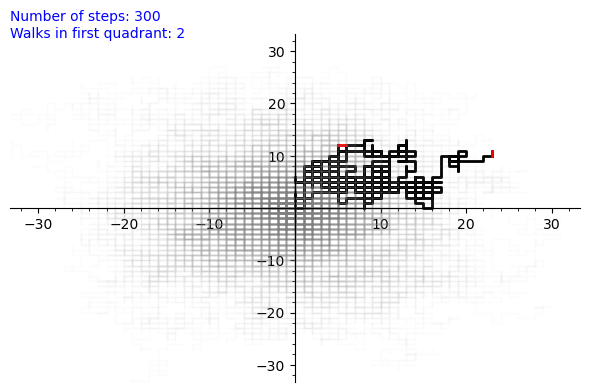

In [2]:
# Define a set of steps
ST = [[1,0],[-1,0],[0,1],[0,-1]]

# Define the length of the walks (N) and the number of walks (K)
N = 300
K = 300

# Generate steps for K random walks of length N 
StepSeq = [[choice(ST) for k in range(N)] for j in range(K)]

# Generate the random walks and find maximum coordinate
WK = [walkSum(Steps) for Steps in StepSeq]
bd = max(flatten(WK))

# Get sequence of plots and convert to Sage Animation class
ani = animate(plotWalk(WK, N, bd+1))

# Display the final frame of the animation
ani[-1]

In [3]:
# Output and save the animation -- this *requires* extra software such as ImageMagick or ffmpeg
# Uncomment and run the following line to save the animation
# ani.save("WalkAnimation.mp4")

## 2. Complexity of Computing Virahanka-Fibonacci Numbers
The Virahanka-Fibonacci Numbers satisfy the recurrence relation $f_{n+2} = f_{n+1} + f_n$ for all $n \geq 0$, together with the initial conditions $f_0=f_1=1$.

#### Naive Function to Compute Terms

In [4]:
# The following recursive function directly encodes the recurrence
# Note: '@cached_function' saves previously returned function values
# in memory, otherwise even computing the 100th term takes a *long* time
@cached_function
def fib(n):
    if n==0 or n==1:
        return 1;
    else:
        return fib(n-1) + fib(n-2)

print([fib(k) for k in range(10)])

[1, 1, 2, 3, 5, 8, 13, 21, 34, 55]


In [5]:
# This is quite inefficient -- roughly, to compute the Nth term takes N^2*log(N) operations
# Note: running this cell more than once will give incorrect timings because of '@cached_function'
# Note: trying to compute more than the 1000th term will cause Sage to exceed its recursion depth
timeit('fib(10^2)')

625 loops, best of 3: 488 ns per loop

#### Binary Powering of a Matrix

In [6]:
# The Fibonacci recurrence can be encoded as a matrix-vector product
M = Matrix(ZZ,2,2,[1,1,1,0])
v = Matrix(ZZ,2,1,[1,1])
print([(M^k * v)[1,0] for k in range(10)])

[1, 1, 2, 3, 5, 8, 13, 21, 34, 55]


In [7]:
# To compute the Nth sequence term one can thus compute the Nth power of M
# This can be done efficiently using 'binary powering'
# Note: Sage has some built-in optimizations for matrix powers but we use this function to be explicit
def bin_pow(x,n):
    if n<=0:
        raise TypeError('Enter a positive integer')
    elif n==1:
        return x
    # When n is even
    elif n%2 == 0:
        return bin_pow(x,n/2)^2
    # When n is odd
    else:
        return bin_pow(x,(n-1)/2)^2*x

In [8]:
# Matrix binary powering is much more efficient than the naive approach
timeit('bin_pow(M,10^2)')

625 loops, best of 3: 27.5 μs per loop

In [9]:
# Here is the millionth Virahanka-Fibonacci Number
# It has 208,988 digits, so we print an approximation (remove '.n()' to see the exact value)
(bin_pow(M,10^6) * v)[1,0].n()

3.16047687386690e208987

#### Polynomial Multiplication in a Quotient Ring

In [10]:
# The Fibonacci recurrence can also be encoded by a polynomial product
# First, define the quotient ring K = Q[x]/(x^2-x-1)
R.<x> = QQ['x']
J = R.ideal(x^2-x-1)
K = R.quo(J)

# Make xb the image of x in the residue ring K
xb = K(x)

# The nth Fibonacci number is the sum of the coefficients in xb^n
print([(xb^k).lift().subs(x=1) for k in range(10)])

[1, 1, 2, 3, 5, 8, 13, 21, 34, 55]


In [11]:
timeit('bin_pow(M,10^2)')

625 loops, best of 3: 26.9 μs per loop

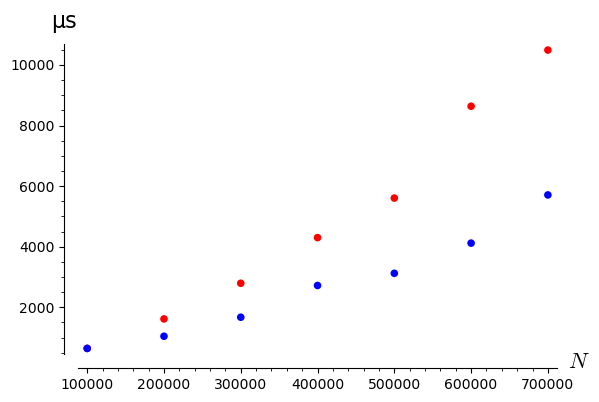

In [12]:
# Using our refined approachs takes roughly N*log^2(N) operations to compute f_N.
# First, a helper function to parse the output of Sage's timeit command
def format_time(t): 
    a = t.stats
    if a[-1] == 's':
        return 10^6 * a[-2]
    elif a[-1] == 'ms':
        return 10^3 * a[-2]
    elif a[-1] == 'μs':
        return a[-2]
    elif a[-1] == 'ns':
        return 10^(-3) * a[-2]

# Now we time our methods on computing f_n for n = k*10^5 with k = 1,...,7
# Then plot the results (the linear complexity can be seen in the plots)
timesM = [timeit('bin_pow(M,' + str(k) + '*10^5)') for k in range(1,8)]
ptM = point([(k*10^5,format_time(timesM[k-1])) for k in range(1,8)], color='red', size=30, axes_labels=['$N$', 'μs'])
timesQ = [timeit('bin_pow(xb,' + str(k) + '*10^5)') for k in range(1,8)]
ptQ = point([(k*10^5,format_time(timesQ[k-1])) for k in range(1,8)], size=30, axes_labels=['$N$', 'μs'])
ptM + ptQ

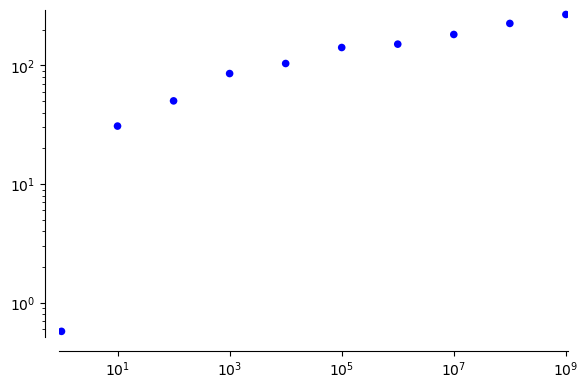

In [13]:
# Note: the linear complexity of the computation comes from 
# the coefficient growth of the polynomial powers. Working modulo 
# a prime results in a *logarthmic* complexity. For instance, here
# is the timing plot computing terms modulo 3.
R3.<x> = GF(3)['x']
J3 = R3.ideal(x^2-x-1)
K3 = R3.quo(J3)
xb2 = K3(x)
timesQ3 = [timeit('bin_pow(xb2,10^' + str(k) + ')') for k in range(10)]
point([(10^k,format_time(timesQ3[k])) for k in range(10)], scale="loglog", size=30)

## 3. Limit Theorems for the Euclidean GCD Algorithm Over Finite Fields
Let $e_{k,n}$ denote the number of pairs of polynomials $(f,g)$ over the finite field of prime order $p$ such that $f$ is monic, $n = \deg f > \deg g$, and Euclid's gcd algorithm applied to $(f,g)$ performs $k$ divisions. The terms $e_{k,n}$ approach a normal distribution as $n\rightarrow\infty$. Below we randomly generate polynomial pairs in finite fields, count the number of divisions performed by the Euclidean algorithm, and compare the experimental results to the limiting distribution.

#### Code to Plot the Number of Divisions on Random Polynomial Pairs vs Limit Distribution

In [14]:
# Define the polynomial ring GF(p)[x]
# CHANGE THE PRIME HERE IF YOU WANT TO PLAY AROUND
p = 3
R = PolynomialRing(GF(p),'x')
S = Integers(p)
x = R.gen()

# EASteps(A,B,0) returns the number of steps the Euclidean algorithm 
# takes for the polynomials A and B
def EASteps(A,B,steps):
    if B == 0: 
        return steps
    (q,r) = A.quo_rem(B)
    return EASteps(B,r,steps+1)

# Generate uniformly random polynomial of degree at most D
def rpol(D):
    return add([S.random_element() * x^k for k in range(D+1)])

# Returns the number of steps the Euclidean algorithm takes for a 
# random pair of polynomials with the larger one monic of degree D
def randomEASteps(D):
    f = x^D + rpol(D-1)
    g = rpol(D-1)
    return EASteps(f,g,0)

# Define limiting density
var('s n P')
density = sqrt(2)*exp(-n*(s/n-1+1/P)^2*P^2/(2*(P-1)))/(2*sqrt(pi*n)*sqrt((P-1)/P^2))
show("The limiting density for the Euclidean Algorithm on polynomial pairs in \t", R," is \t", density.subs(P=p))

'The limiting density for the Euclidean Algorithm on polynomial pairs in \t' Univariate Polynomial Ring in x over Finite Field of size 3 ' is \t' 3/2*e^(-1/4*n*(3*s/n - 2)^2)/sqrt(pi*n)

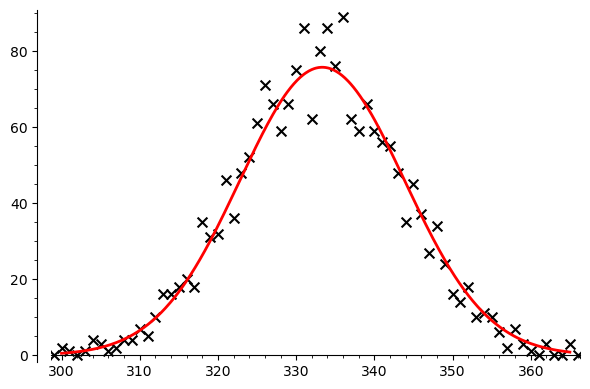

In [15]:
# Set maximum degree (N) and number of pairs (K) of polynomials to generate
# With the default p = 3, N = 500, and K = 2000 this should take 5 - 10 seconds
# CHANGE N and K HERE IF YOU WANT TO PLAY AROUND
N = 500
K = 2000

# Generate list of division counts for K random polynomial pairs
lst = [randomEASteps(N) for k in range(K)]

# Plot the count of points
p1 = plot(point([(k,lst.count(k)) for k in range(N)],size=50,marker="x", color="black"))
# Plot the limiting density (scaled to count divisions instead of probabilities)
p2 = plot(K*density.subs(n=N,P=p),(min(lst),max(lst)), color="red", thickness=2)
# Superimpose the plots
pt = p1 + p2
# Set the axes of the plot
pt.axes_range(xmin=min(lst),xmax=max(lst),ymin=0,ymax=pt.get_minmax_data()['ymax'])
# Display the plot on screen
pt

#### Code to Animate Limit Theorems for the Euclidean GCD Algorithm Over Finite Fields

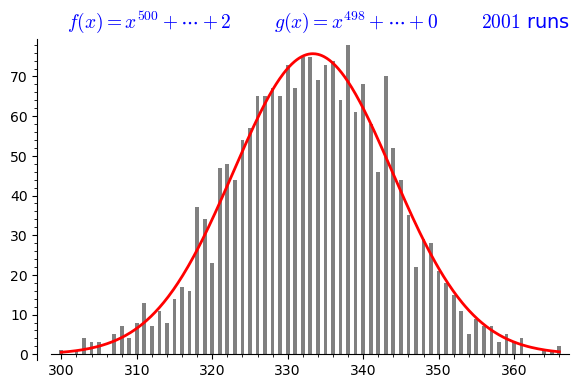

In [16]:
# Returns the number of steps the Euclidean algorithm takes for a 
# random pair of polynomials with the larger one monic of degree D
# *and* the polynomials used
def randomEAStepsfg(D):
    f = x^D + rpol(D-1)
    g = rpol(D-1)
    return f,g,EASteps(f,g,0)

# Set maximum degree (N) and number of pairs (K) of polynomials to generate
N = 500
K = 2000

# Generate and record a sequence of K polynomial pairs with max degree N,
# together with the count of divisions performed by the Euclidean Algorithm
f_lst = []
g_lst = []
ct_lst = []
for step in range(K+1):
    f, g, ct = randomEAStepsfg(N)
    f_lst += [f]
    g_lst += [g]
    ct_lst += [ct]

# Generate a list of plots animating the running count of divisions 
# compared to the expected count from the limit density
PT = []
ym = -1
for L in range(201):
    step = 10*L
    p1 = bar_chart([ct_lst[0:step+1].count(k) for k in range(N)], color='gray')
    p2 = plot((step+1)*density.subs(n=N,P=p),(min(ct_lst),max(ct_lst)), color="red", thickness=2)
    pt = p1 + p2
    ym = max(ym,pt.get_minmax_data()['ymax'])
    F = f_lst[step]
    G = g_lst[step]
    pt += text("$%s$" %("f(x) = " + latex(F.lt()) + "+ \\cdots +" + latex(F.constant_coefficient())),(0.03,1.05),axis_coords=True, horizontal_alignment="left", fontsize=14)
    pt += text("$%s$"  %("g(x) = " + latex(G.lt()) + "+ \\cdots +" + latex(G.constant_coefficient())),(0.43,1.05),axis_coords=True, horizontal_alignment="left", fontsize=14)
    pt += text("$%s$ runs"  %(step+1),(0.83,1.05),axis_coords=True, horizontal_alignment="left", fontsize=14)
    pt.axes_range(xmin=min(ct_lst),xmax=max(ct_lst),ymin=0,ymax=ym)
    PT += [pt]

# Generate an animation object from the list of plots
ani = animate(PT)

# Display the final frame of the animation
ani[-1]

In [17]:
# Output and save the animation -- this *requires* extra software such as ImageMagick or ffmpeg
# Uncomment and run the following line to save the animation
# ani.save("EuclidAnimation.mp4")